In [1]:
%time

import os

print(os.path.abspath(os.curdir))

Wall time: 0 ns
C:\Users\arez_\PycharmProjects\AMLS_19-20_Muhammad_Juzaimi_SN16072927


In [2]:
os.chdir('./AMLS_19-20_SN16072927')
# os.chdir('..')
print(os.path.abspath(os.curdir))

C:\Users\arez_\PycharmProjects\AMLS_19-20_Muhammad_Juzaimi_SN16072927\AMLS_19-20_SN16072927


In [3]:
from sklearn.model_selection import train_test_split
import pickle

def get_data():

    with open('X_B1_saved.dat', 'rb') as f:
        X_B1_load = pickle.load(f)
    
    with open('Y_B1_saved.dat', 'rb') as f:
        Y_B1_load = pickle.load(f)
    
    tr_X_B1, te_X_B1, tr_Y_B1, te_Y_B1 = train_test_split(X_B1_load, Y_B1_load, test_size=0.3)

    return tr_X_B1, te_X_B1, tr_Y_B1, te_Y_B1

In [4]:
tr_X_B1, te_X_B1, tr_Y_B1, te_Y_B1 = get_data()

Wall time: 0 ns


In [5]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

def SVM_B1(training_images, training_labels, test_images, test_labels):
    tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100]},
                        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                        {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100]}
                        ]


    classifierB1 = GridSearchCV(svm.SVC(), tuned_parameters, n_jobs=-1)  # gridsearchCV use 3 k-fold by default
    classifierB1.fit(training_images, training_labels)
    print(classifierB1.best_params_)
# default score of SVM is accuracy
    acc_B1_train = classifierB1.best_score_
    
    cv_score = classifierB1.cv_results_

# prediction using best classifier choose by GridSearchCV
    predB1 = classifierB1.best_estimator_.predict(test_images)

    acc_B1_test = accuracy_score(test_labels, predB1)
    
    return acc_B1_train, acc_B1_test, predB1, cv_score

Wall time: 0 ns


In [7]:
import time
starttime = time.time()
model_B1 = SVM_B1(tr_X_B1, tr_Y_B1, te_X_B1, te_Y_B1)
stoptime = time.time()
print(stoptime - starttime)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


1902.8664407730103


In [29]:
acc_B1_train, acc_B1_test, predB1, cv_score = model_B1

In [30]:
print('TB1:{},{}'.format(acc_B1_train, acc_B1_test))

TB1:0.7617915904936015,0.7646055437100213


In [32]:
temp = pd.DataFrame(cv_score)
print(temp)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       15.230469      0.804443         0.521007        0.019712       1   
1      189.508406     11.175502         0.527589        0.012896      10   
2     1645.551099     98.258352         0.429047        0.014037     100   
3        4.984471      0.155355         0.910764        0.025060       1   
4        7.108989      0.058861         0.988357        0.022943       1   
5        3.841328      0.077445         0.780911        0.049285      10   
6        5.241583      0.091612         0.893211        0.014571      10   
7        4.241658      0.065758         0.608771        0.009197     100   
8        4.061339      0.100641         0.759968        0.005353     100   
9        6.432997      0.023222         0.920140        0.028298       1   
10       6.049023      0.095880         0.856510        0.008795       1   
11       6.938445      0.032757         0.822401        0.005337      10   
12       5.6

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

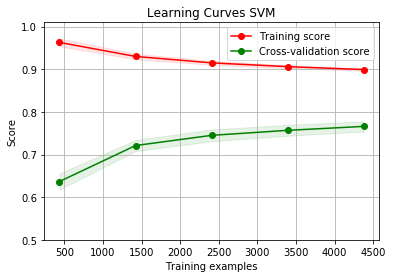

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves SVM"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = svm.SVC(kernel='rbf', gamma=1e-3, C=100)
X, y = tr_X_B1, tr_Y_B1
plot_learning_curve(estimator, title, X, y, (0.5, 1.01), cv=cv, n_jobs=-1)

plt.show()

# default test score for SVM is accuracy

[[368  35  29  12  18]
 [ 47 302  23  28  12]
 [ 20  28 399  61  17]
 [ 15  44  49 325  21]
 [ 19  18  34   5 416]]


<function matplotlib.pyplot.show(*args, **kw)>

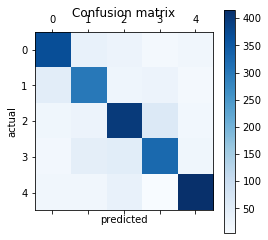

In [16]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

test_label = te_Y_B1
cf = confusion_matrix(test_label, predB1)
print(cf)

cmap = plt.cm.Blues

plt.matshow(cf, cmap = cmap)
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show